# Similarity Modeling 1/2: Recognizing Waldorf & Statler

## Student
Gallus Huber (51905700)

## Timesheet
2022-12-28 18:00 - 21:30 Setup <br />
2022-12-29 09:00 - 12:00 Exploration <br />
2022-01-03 09:00 - 11:00 Data preparation <br />

## Required libraries and installs

In [1]:
!cat requirements-fe-audio.txt
!pip install -r requirements-fe-audio.txt

pandas
numpy
opencv-python
matplotlib
librosaLooking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

## Imports

In [1]:
import os
import glob
import pathlib

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt

import librosa.display

import sklearn.model_selection as ms
from tqdm import tqdm

## Constants

In [2]:
# path to ground truth and videos
DATA_PATH = "/content/drive/MyDrive/data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
PROCESSED_DATA_PATH = os.path.join(AUDIO_PATH, "processed")

# Project Structure

In [4]:
if not os.path.exists(AUDIO_PATH):
    os.makedirs(AUDIO_PATH)

if not os.path.exists(PROCESSED_DATA_PATH):
    os.makedirs(PROCESSED_DATA_PATH)

OSError: [Errno 30] Read-only file system: '/content'

# 1. Data Preparation

## 1.1 List all videos

In [6]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-03-04-03.avi', 'Muppets-02-01-01.avi', 'Muppets-02-04-04.avi']

## 1.2 Read ground truth from CSV

In [7]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
    file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
    csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
    ground_truth[video] = csv

## 1.3 Plot the ground truth

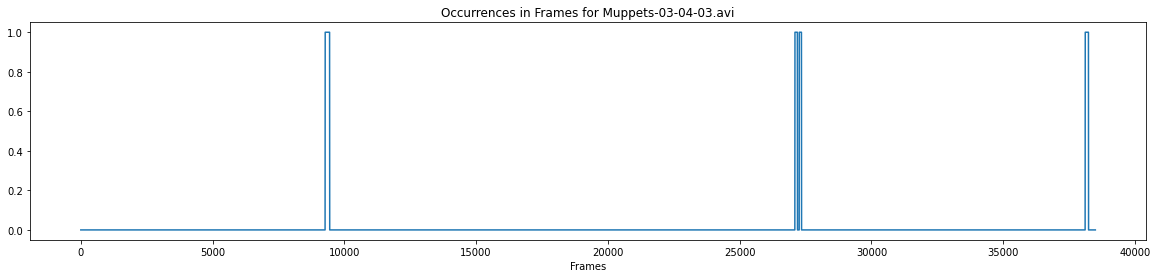

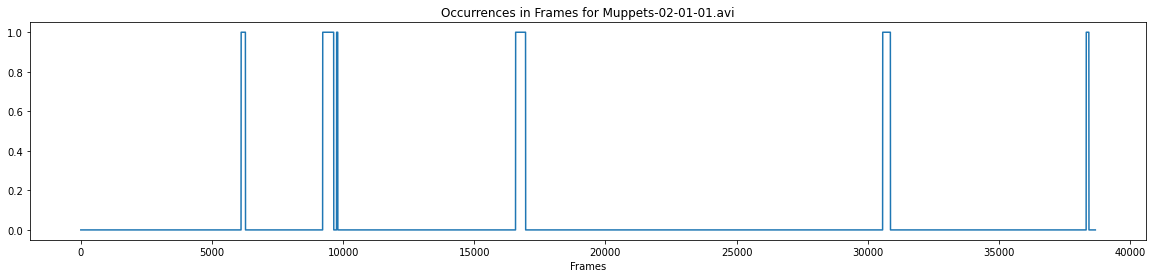

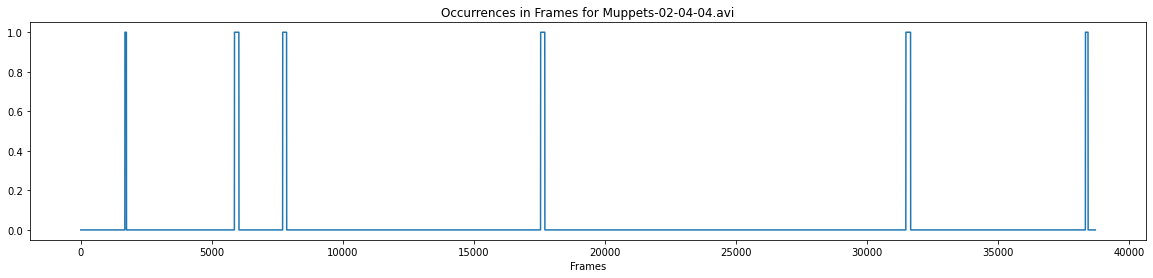

In [8]:
for video in videos:
    plot = plt.figure(figsize=(20, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames for {video}")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(ground_truth[video]['Frame_number']))
    frame_indicator[ground_truth[video][ground_truth[video]["Audio_StatlerWaldorf"] == 1].index] = 1

    subplot.plot(ground_truth[video]["Audio_StatlerWaldorf"].index, frame_indicator)
    plt.show()

## 1.4 Load video data

In [9]:
video_data = dict()

for video in videos:
    file_name = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')
    video_cap = cv2.VideoCapture(os.path.join(file_name[0]))
    video_data[video] = video_cap

## 1.5 FPS Constant

In [10]:
FPS = 25

## 1.6 Combine data frames, filter for Waldorf & Statler and add seconds

In [11]:
df_gt = pd.concat(ground_truth)

df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_StatlerWaldorf"]]
df_gt.head()

Video  Frame_number  Seconds  Audio_StatlerWaldorf
Muppets-03-04-03.avi 0    343             0     0.00                     0
                     1    343             1     0.04                     0
                     2    343             2     0.08                     0
                     3    343             3     0.12                     0
                     4    343             4     0.16                     0

## 1.7 Mapping Filename - Video

In [12]:
video2filename = {"Muppets-02-01-01.avi": 211, "Muppets-02-04-04.avi": 244, "Muppets-03-04-03.avi": 343}

## 1.8 Convert .avi to .wav

In [13]:
for video in videos:
    file_name_video = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')[0]
    file_name_audio = os.path.join(AUDIO_PATH, os.path.splitext(video)[0] + '.wav')
    command2wav = f"ffmpeg -i {file_name_video} {file_name_audio}"

    os.system(command2wav)

    # save audio filename to data frame
    df_gt.loc[df_gt["Video"] == video2filename[os.path.splitext(video)[0] + ".avi"], "file_name_audio"] = os.path.splitext(video)[0] + ".wav"

df_gt.head()

Video  Frame_number  Seconds  Audio_StatlerWaldorf  \
Muppets-03-04-03.avi 0    343             0     0.00                     0   
                     1    343             1     0.04                     0   
                     2    343             2     0.08                     0   
                     3    343             3     0.12                     0   
                     4    343             4     0.16                     0   

                             file_name_audio  
Muppets-03-04-03.avi 0  Muppets-03-04-03.wav  
                     1  Muppets-03-04-03.wav  
                     2  Muppets-03-04-03.wav  
                     3  Muppets-03-04-03.wav  
                     4  Muppets-03-04-03.wav

## 1.8 Explore data

### 1.8.1 Constants

In [14]:
SAMPLE_RATE = 16000  # we will use a sample rate of 16kHz
N_FFT = 320  # = 20ms @ 16kHz
HOP_LENGTH = 160  # = 10ms @ 16kHz
N_MELS = 64

### 1.8.2 Load Signals

In [15]:
signals = dict()
sample_rates = dict()
for file_name in df_gt["file_name_audio"].unique():
    signals[file_name], sample_rates[file_name] = librosa.load(os.path.join(AUDIO_PATH, file_name), sr=SAMPLE_RATE)

### 1.8.3 Waveplot

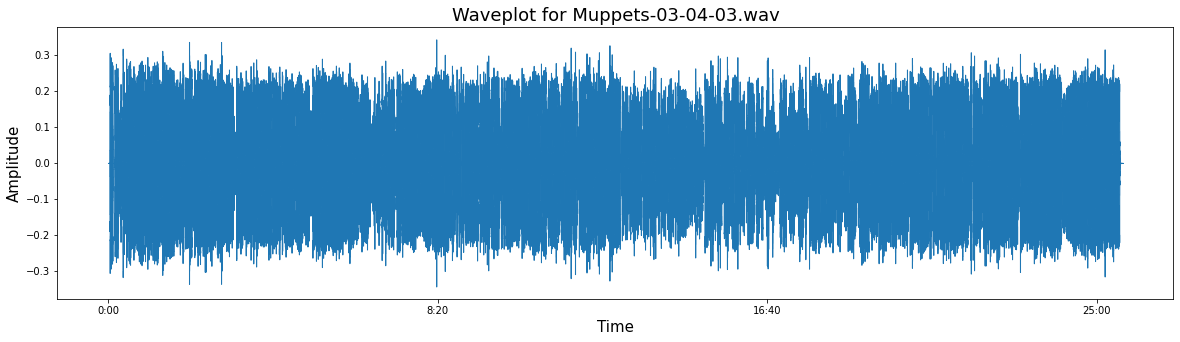

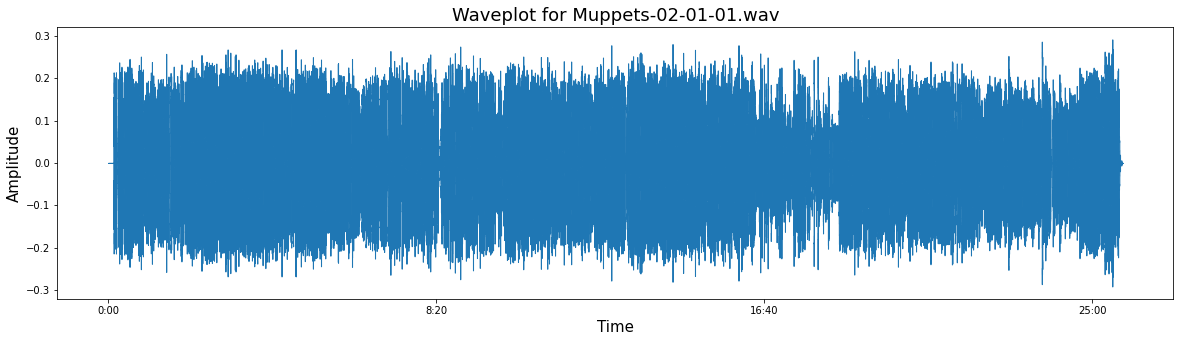

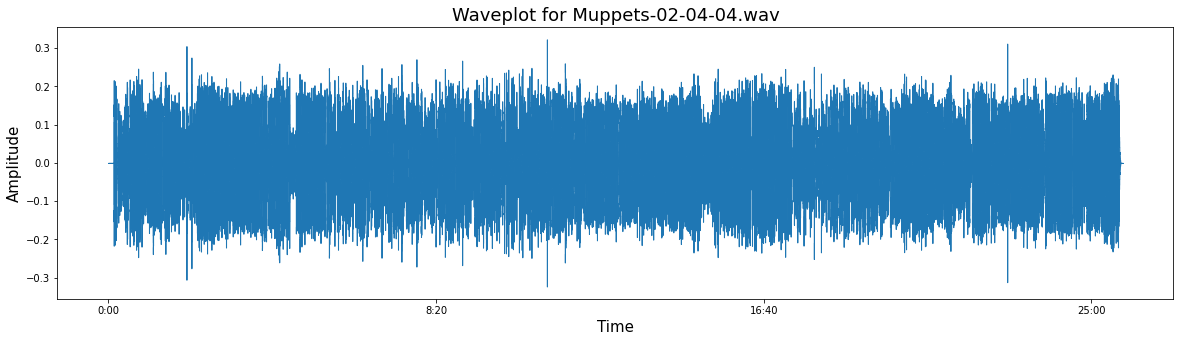

In [16]:
for file_name in df_gt["file_name_audio"].unique():
    plt.figure(figsize=(20, 5))
    plt.title(f"Waveplot for {file_name}", fontdict=dict(size=18))
    plt.xlabel("Time", fontdict=dict(size=15))
    plt.ylabel("Amplitude", fontdict=dict(size=15))

    librosa.display.waveshow(signals[file_name], sr=sample_rates[file_name])
    plt.show()

### 1.8.4 Zero crossing rate

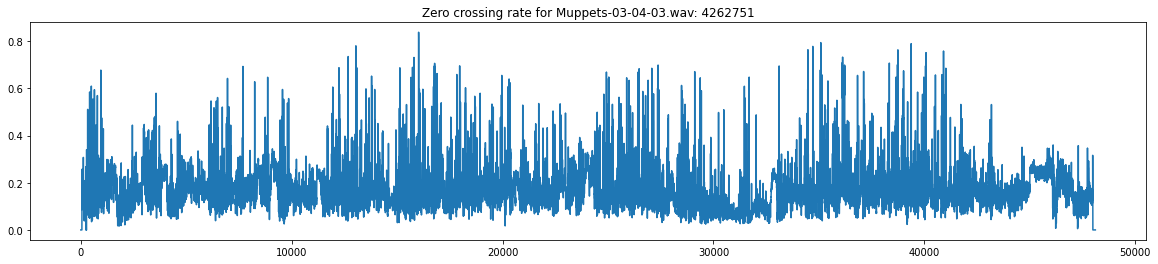

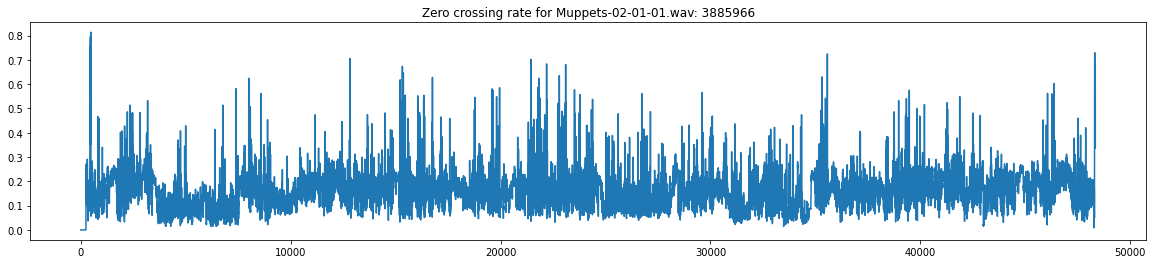

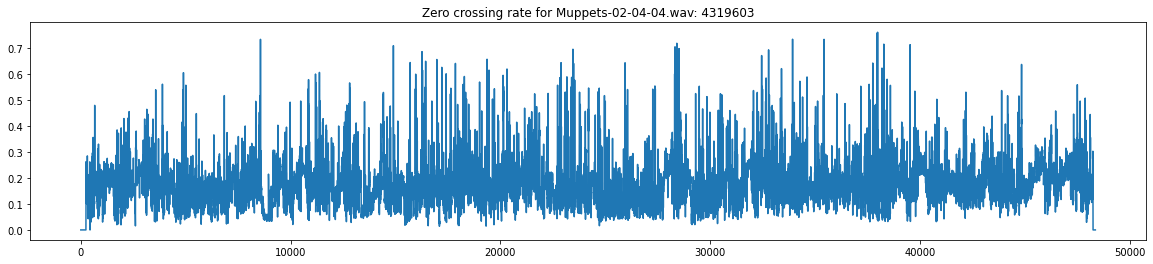

In [18]:
for file_name in df_gt["file_name_audio"].unique():
    zcr = librosa.feature.zero_crossing_rate(signals[file_name])

    plt.figure(figsize=(20, 4))
    plt.plot(zcr[0])
    plt.title(label=f"Zero crossing rate for {file_name}: {sum(librosa.zero_crossings(signals[file_name]))}")

### 1.8.5 Mel spectrograms

In [ ]:
spectrograms = dict()

for file_name in df_gt["file_name_audio"].unique():
    spectrograms[file_name] = librosa.feature.melspectrogram(
        y=signals[file_name], sr=sample_rates[file_name],n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )

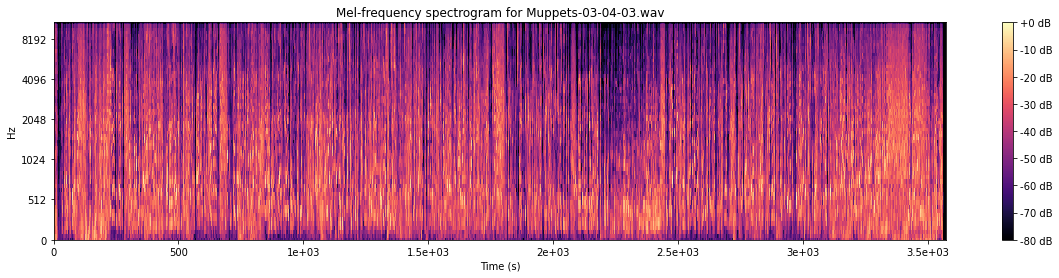

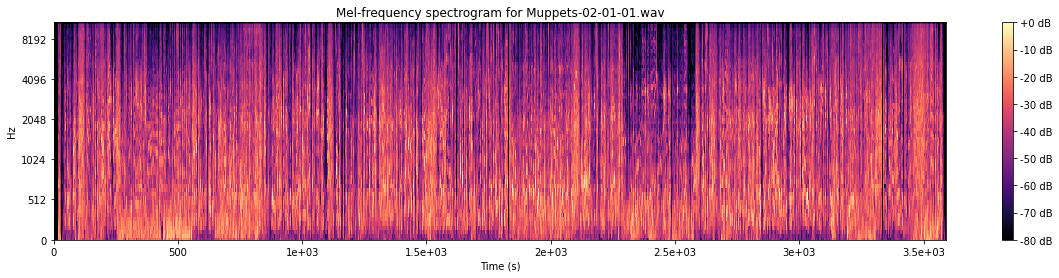

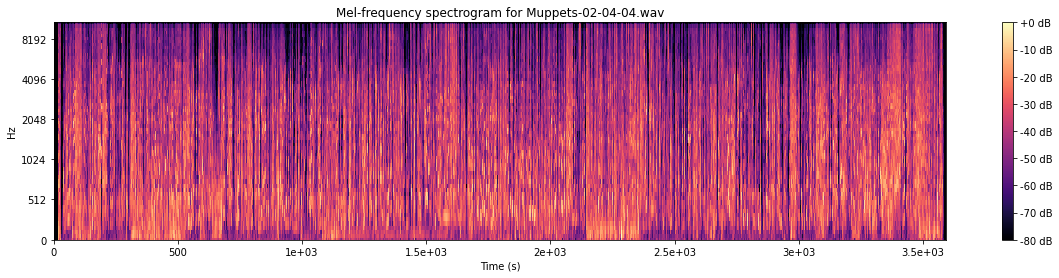

In [19]:
for file_name in df_gt["file_name_audio"].unique():
    figure, axis = plt.subplots(figsize=(20, 4))
    power_to_db = librosa.power_to_db(spectrograms[file_name], ref=np.max)

    image = librosa.display.specshow(power_to_db, x_axis="s", y_axis="mel", ax=axis)
    figure.colorbar(image, ax=axis, format="%+2.0f dB")
    axis.set(title=f"Mel-frequency spectrogram for {file_name}")

    plt.show()

# 2 Data preparation

## 2.1 Create splits

In [ ]:
train_data, valid_test_data = ms.train_test_split(df_gt, test_size=0.2, shuffle=True, random_state=42)
valid_data, test_data = ms.train_test_split(valid_test_data, test_size=0.25, random_state=42)

fig, axs = plt.subplots(3)
rects_train = axs[0].hist(train_data["Audio_StatlerWaldorf"])
axs[0].set_title("Train Data")

rects_val = axs[1].hist(valid_data["Audio_StatlerWaldorf"])
axs[1].set_title("Validation Data")

rects_test = axs[2].hist(test_data["Audio_StatlerWaldorf"])
axs[2].set_title("Test Data")

plt.tight_layout()
plt.show()

## 2.2 Create X,y array from spectrograms

In [ ]:
def create_xy_from_spectrograms(df, sg):
    stv_rate = 4
    context_size = 16

    x = []
    y = []
    frame_unsuccessful = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        # find middle spectrogram frames corresponding to video frame label
        spec_slice_horizontal_label = slice(row["Frame_number"] * stv_rate, (row["Frame_number"] + 1) * stv_rate)
        spec = sg[row["file_name_audio"]]
        label_snippet = spec[:, spec_slice_horizontal_label]

        if label_snippet.shape[1] < 4:
            frame_unsuccessful.append(str(row['Video']) + '_' + str(row['Frame_number']))
        else:
            # create full snippet with context frames filled with zeros
            full_snippet = np.zeros((spec.shape[0], 2*context_size + stv_rate))

            # place label snippet in the middle
            full_snippet[:, context_size:context_size + stv_rate] = label_snippet

            # find context
            # context_size frames before the actual frames
            context_pre = spec[:, row["Frame_number"] * stv_rate - context_size:row["Frame_number"] * stv_rate]

            # context_size frames after the actual frames
            context_post = spec[:, (row["Frame_number"] + 1) * stv_rate:(row["Frame_number"] + 1) * stv_rate + context_size]

            # place context in full snippet
            # fill from index context_size to left with context_pre
            full_snippet[:, context_size-context_pre.shape[1]:context_size] = context_pre

            # fill after label frames with context_post
            full_snippet[:, context_size+stv_rate:context_size+stv_rate+context_post.shape[1]] = context_post

            x.append(full_snippet)
            y.append(row["Audio_StatlerWaldorf"])

    x = np.dstack(x)
    x = np.swapaxes(x, 0, 2)
    x = np.swapaxes(x, 1, 2)
    x = np.expand_dims(x, axis=3)
    y = np.array(y)

    print(f"Created X array with shape {x.shape}")
    print(f"Created y array with shape {y.shape}")
    print(f"For {len(frame_unsuccessful)} video frames, we did not find a spectrogram frame")

    return x, y, frame_unsuccessful

X_train_A2, y_train_A2, fu_train_A2 = create_xy_from_spectrograms(train_data, spectrograms)
X_val_A2, y_val_A2, fu_val_A2 = create_xy_from_spectrograms(valid_data, spectrograms)
X_test_A2, y_test_A2, fu_test_A2 = create_xy_from_spectrograms(test_data, spectrograms)

## 2.3 Store processed data

In [ ]:
with open(os.path.join(PROCESSED_DATA_PATH, "X_train.npy"), 'wb') as f:
          np.save(f, X_train_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_train.npy"), 'wb') as f:
          np.save(f, y_train_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_valid.npy"), 'wb') as f:
          np.save(f, X_val_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_valid.npy"), 'wb') as f:
          np.save(f, y_val_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_test.npy"), 'wb') as f:
          np.save(f, X_test_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_test.npy"), 'wb') as f:
          np.save(f, y_test_A2, allow_pickle=False)

## 2.4 Load spectrogram snippets

In [ ]:
if os.path.exists(PROCESSED_DATA_PATH):
    with open(os.path.join(PROCESSED_DATA_PATH, "X_train.npy"), 'rb') as f:
          X_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_train.npy"), 'rb') as f:
          y_train = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_valid.npy"), 'rb') as f:
          X_valid = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_valid.npy"), 'rb') as f:
          y_valid = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_test.npy"), 'rb') as f:
          X_test = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_test.npy"), 'rb') as f:
          y_test = np.load(f)

print("Loaded spectrogram snippets from disk")

## 2.5 Standardize features

In [ ]:
mean = X_train.mean()
std = X_train.std()

print(f"Mean of X_train: {mean}")
print(f"Std of X_train: {std}")

X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std